# 信用卡反欺诈模型 (Credit Card Fraud Detection)

## 1. 项目背景与目标

本项目旨在利用真实的信用卡交易数据，构建一个能够实时识别欺诈交易的机器学习模型。该数据集存在一个核心挑战：**数据极度不平衡**，欺诈交易（正样本）仅占总交易量的0.172%。这要求我们必须采用特殊的处理方法和评估指标，来构建一个在实际业务中有价值的模型。

**核心目标:**
1.  对数据进行探索性分析(EDA)，理解欺诈交易在金额和时间上的分布特征。
2.  应用**SMOTE(合成少数类过采样技术)**来解决数据不平衡问题。
3.  搭建并对比**逻辑回归**和**孤立森林**等模型，评估其在欺诈检测任务上的性能。
4.  使用**AUPRC (Precision-Recall曲线下面积)**、Recall、Precision等关键指标，科学地衡量模型在不平衡场景下的真实能力。

## 2. 数据加载与探索性分析(EDA)

在这一部分，我们将加载数据集，并对`Time`和`Amount`这两个具有业务含义的特征进行初步分析，观察欺诈交易与正常交易在这些维度上的差异。

Dataset shape: (284807, 31)

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.

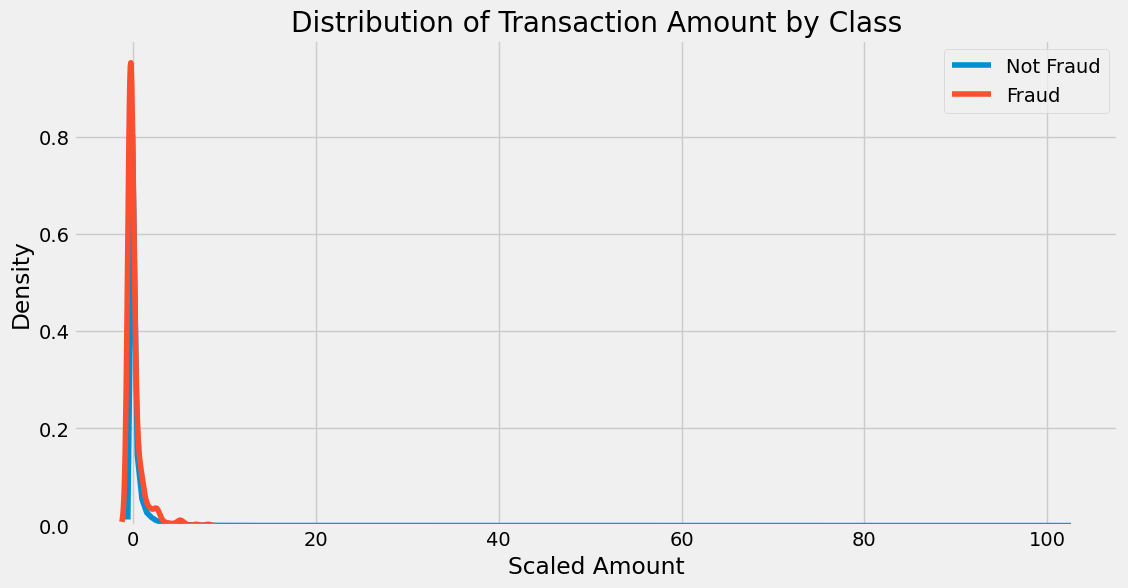

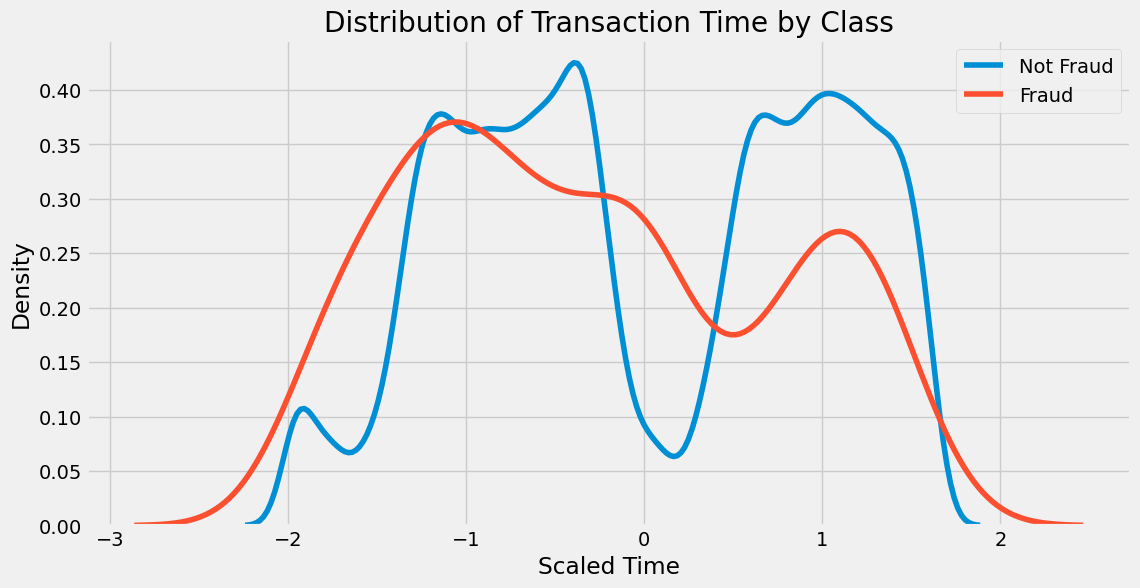

In [1]:
# -----------------------------------
# 1. 导入基础库
# -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 导入模型和评估工具
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# 导入SMOTE
from imblearn.over_sampling import SMOTE


# -----------------------------------
# 2. 设置与数据加载
# -----------------------------------
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# 加载数据
df = pd.read_csv('creditcard.csv')

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# 查看目标变量分布
print("\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraudulent transactions percentage: {df['Class'].value_counts()[1] / len(df) * 100:.3f}%")


# -----------------------------------
# 3. 数据预处理与EDA
# -----------------------------------
# 标准化 Amount 和 Time 特征
# StandardScaler 会将数据转换为均值为0，方差为1的正态分布
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 丢弃原始的 Time 和 Amount 列
df = df.drop(['Time', 'Amount'], axis=1)

# 可视化欺诈与正常交易的金额分布
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['Class'] == 0]['scaled_amount'], label='Not Fraud')
sns.kdeplot(df[df['Class'] == 1]['scaled_amount'], label='Fraud')
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Scaled Amount')
plt.legend()
plt.show()

# 可视化欺诈与正常交易的时间分布
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df['Class'] == 0]['scaled_time'], label='Not Fraud')
sns.kdeplot(df[df['Class'] == 1]['scaled_time'], label='Fraud')
plt.title('Distribution of Transaction Time by Class')
plt.xlabel('Scaled Time')
plt.legend()
plt.show()

# 3. 数据平衡与基线模型

为了解决数据极度不平衡的问题，我们不能直接在原始数据上训练模型。在本节中，我们将采用SMOTE（合成少数类过采样技术）方法，在数据进入模型训练之前，对训练集进行“平衡”处理。

同时，我们将构建一个**逻辑回归(Logistic Regression)**模型作为**基线模型(Baseline Model)**。基线模型的意义在于提供一个性能的“底线”，我们后续更复杂的模型，其性能表现必须超越这个基线，才能证明其有效性。

**本节目标:**
1.  将数据划分为训练集和测试集。
2.  对**训练集**应用SMOTE算法，生成一个平衡的数据集。
3.  在平衡后的训练集上训练逻辑回归模型。
4.  在**原始的、不平衡的测试集**上评估模型性能，并解读结果。

Original training set shape (199364, 30)
Original training set labels distribution Class
0    199020
1       344
Name: count, dtype: int64

Applying SMOTE to the training data...
Resampled training set shape (398040, 30)
Resampled training set labels distribution Class
0    199020
1    199020
Name: count, dtype: int64

Training Logistic Regression model...

Evaluating the model...

Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      0.98      0.99     85295
    Fraud (1)       0.06      0.88      0.12       148

     accuracy                           0.98     85443
    macro avg       0.53      0.93      0.55     85443
 weighted avg       1.00      0.98      0.99     85443

Area Under the Precision-Recall Curve (AUPRC): 0.7428


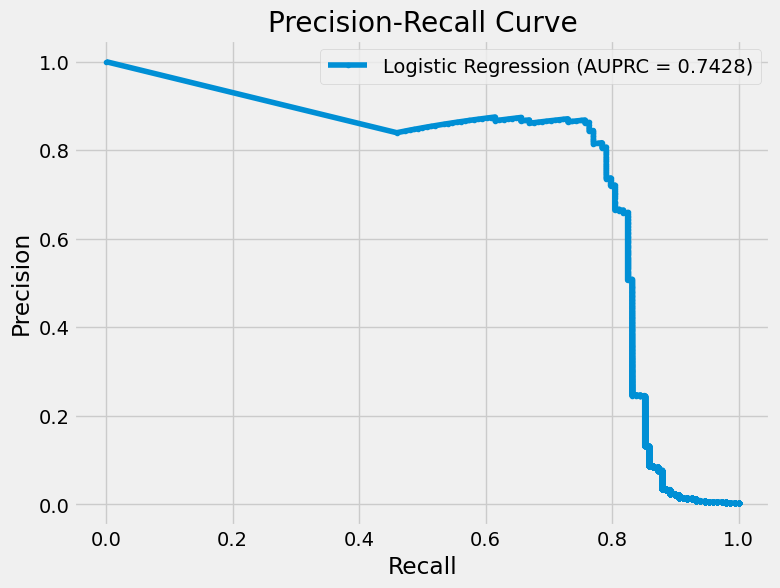

In [ ]:
# -----------------------------------
# 1. 准备数据
# -----------------------------------
# X 是我们的特征, y 是我们的目标标签
X = df.drop('Class', axis=1)
y = df['Class']

# 按照 70:30 的比例划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Original training set shape %s" % str(X_train.shape))
print("Original training set labels distribution %s" % str(y_train.value_counts()))

# -----------------------------------
# 2. 应用 SMOTE
# -----------------------------------
print("\nApplying SMOTE to the training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled training set shape %s" % str(X_train_resampled.shape))
print("Resampled training set labels distribution %s" % str(y_train_resampled.value_counts()))


# -----------------------------------
# 3. 训练逻辑回归模型
# -----------------------------------
print("\nTraining Logistic Regression model...")
# class_weight='balanced' 可以给模型一个额外的提示，来处理不平衡问题，但我们主要依赖SMOTE
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)


# -----------------------------------
# 4. 预测与评估
# -----------------------------------
print("\nEvaluating the model...")
# 在原始的、不平衡的测试集上进行预测
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# 打印分类报告，包含Precision, Recall, F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

# 计算并打印 AUPRC (PR-AUC)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Area Under the Precision-Recall Curve (AUPRC): {pr_auc:.4f}")

# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Logistic Regression (AUPRC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 4. 异常检测模型：孤立森林 (Isolation Forest)

逻辑回归是一个通用的分类模型，而反欺诈问题在本质上也可以看作是一个**异常检测(Anomaly Detection)**问题——欺诈交易是与绝大多数正常交易行为模式不同的“异常点”。

因此，我们尝试使用专门为异常检测设计的无监督模型——**孤立森林(Isolation Forest)**。这个模型不需要SMOTE，它可以直接在原始的、不平衡的数据上工作，通过“孤立”离群点来识别欺诈。

**本节目标:**
1.  在原始不平衡数据上训练孤立森林模型。
2.  评估其性能，并与之前的逻辑回归模型进行对比。


Training Isolation Forest model...

Evaluating the Isolation Forest model...

Isolation Forest Classification Report:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00     85295
    Fraud (1)       0.28      0.27      0.28       148

     accuracy                           1.00     85443
    macro avg       0.64      0.63      0.64     85443
 weighted avg       1.00      1.00      1.00     85443

Isolation Forest AUPRC: 0.1991


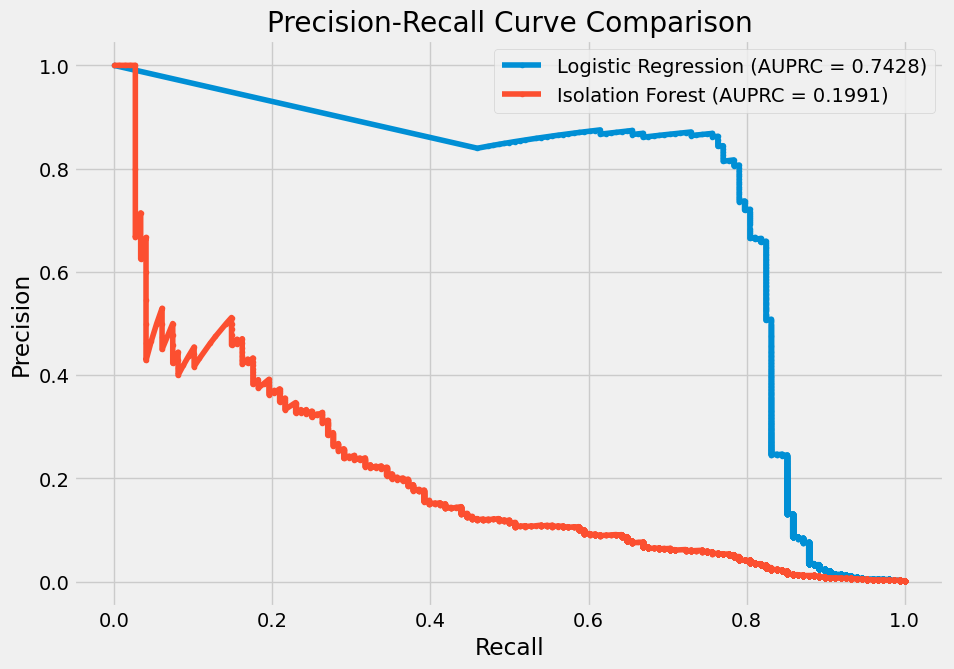

In [ ]:
# -----------------------------------
# 1. 定义和训练孤立森林模型
# -----------------------------------
print("\nTraining Isolation Forest model...")

# 设定 contamination 参数为我们已知的欺诈比例
iso_forest = IsolationForest(n_estimators=100, contamination=0.00172, random_state=42, n_jobs=-1)

iso_forest.fit(X_train)


# -----------------------------------
# 2. 预测与评估
# -----------------------------------
print("\nEvaluating the Isolation Forest model...")
# predict方法返回-1（异常）和1（正常）
y_pred_iso = iso_forest.predict(X_test)

# 我们需要将-1和1转换为我们需要的1和0
# 异常(-1) -> 欺诈(1)
# 正常(1)  -> 正常(0)
y_pred_iso_mapped = np.where(y_pred_iso == -1, 1, 0)

# decision_function 返回每个样本的异常分数，分数越低越可能是异常
# 我们需要转换一下，让它变成“是欺诈的概率”，便于计算AUPRC
y_pred_proba_iso = -iso_forest.decision_function(X_test)


# -----------------------------------
# 3. 结果展示与对比
# -----------------------------------
print("\nIsolation Forest Classification Report:")
print(classification_report(y_test, y_pred_iso_mapped, target_names=['Not Fraud (0)', 'Fraud (1)']))

# 计算并打印 AUPRC
precision_iso, recall_iso, _ = precision_recall_curve(y_test, y_pred_proba_iso)
pr_auc_iso = auc(recall_iso, precision_iso)
print(f"Isolation Forest AUPRC: {pr_auc_iso:.4f}")

# 将两个模型的PR曲线画在一起，进行对比
plt.figure(figsize=(10, 7))
# 逻辑回归的曲线
plt.plot(recall, precision, marker='.', label=f'Logistic Regression (AUPRC = {pr_auc:.4f})')
# 孤立森林的曲线
plt.plot(recall_iso, precision_iso, marker='.', label=f'Isolation Forest (AUPRC = {pr_auc_iso:.4f})')

plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 5. 结论与项目总结

本项目成功地构建并对比了两种不同思路的信用卡反欺诈模型。通过这个过程，我们得出了在处理极度不平衡数据时的关键洞察。

## 模型性能对比与结论

1.  **SMOTE + 逻辑回归 (有监督分类)**:
    *   **AUPRC**: 0.7428
    *   **表现**: 实现了高达**88%的欺诈召回率(Recall)**，展现出强大的风险发现能力。虽然精确率较低，但作为一个高敏感度的预警系统，其性能非常出色。
2.  **孤立森林 (无监督异常检测)**:
    *   **AUPRC**: 0.1991
    *   **表现**: 性能显著低于逻辑回归。其召回率和精确率都只有27%-28%左右，说明在特征界限模糊的高维空间中，单纯依赖异常检测难以有效识别欺诈。

**最终结论**: 实验结果有力地证明，对于本类反欺诈问题，**采用SMOTE等过采样技术来平衡数据，并结合有监督的分类模型，是远比无监督异常检测更有效的策略**。

## 项目价值与可迁移技能

通过这个项目，我深入实践并掌握了：
*   **处理极度不平衡数据集的核心技术**: 熟练应用**SMOTE**算法，并理解其在模型训练中的关键作用。
*   **选择合适的模型评估指标**: 深刻理解在不平衡场景下，**AUPRC、Recall、Precision**远比Accuracy更重要，并能结合业务场景（如反欺诈中对Recall的高要求）进行解读。
*   **对比不同机器学习方法论**: 能够设计实验，对比有监督与无监督、不同模型（逻辑回归 vs. 孤立森林）的优劣，并从结果中提炼出有价值的结论。
*   **端到端的建模流程**: 熟练掌握从数据预处理（标准化）、模型训练、评估到结果可视化的完整流程。

这些技能不仅可以直接应用于各类金融反欺诈场景，其处理不平衡数据的思想和方法论，也可以广泛迁移到如**罕见病预测、服务器故障检测、高端客户识别**等其他“大海捞针”式的分析任务中。